<a href="https://colab.research.google.com/github/habib-wahid/ML-Assignment/blob/main/Regularized_Logistic_Regression_With_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import copy
import math
import numpy as np
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ls '/content/drive/MyDrive/Data'
data = pd.read_csv('/content/drive/MyDrive/Data/data2.txt', header=None, names = ["x1","x2","y"])
data.head()

,x1,x2,y
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [ ]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data['y'] == 0
    pos = data['y'] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos]['x1'], data[pos]['x2'], marker='+', c='orange', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg]['x1'], data[neg]['x2'], c='blue', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

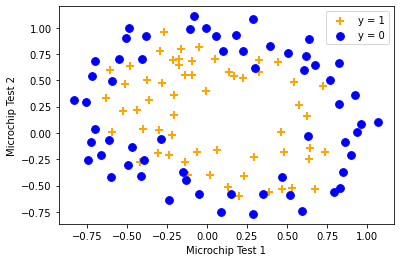

In [ ]:
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

In [ ]:
n = data.shape[1]-1
x = data[data.columns[0:n]]

y = data[data.columns[n:n+1]]
# convert to np.array
X = x.values
y = y.values
y = np.squeeze(np.asarray(y))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
def mapFeature( x1col, x2col):
    degrees = 10
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

In [ ]:
XX = mapFeature(X[:,0],X[:,1])
print(X.shape, XX.shape)


(118, 2) (118, 66)


In [ ]:
from scipy.special import expit #Vectorized sigmoid function

#Hypothesis function and cost function for logistic regression
def h(mytheta,myX): #Logistic hypothesis function
    return expit(np.dot(myX,mytheta))

In [ ]:
def sigmoid(z):
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))
    return g

In [ ]:
def compute_cost_logistic(X, y, w, b):
    """
    Computes cost

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """

    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
             
    cost = cost / m
    return cost

In [ ]:
def compute_gradient_logistic(X, y, w, b): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    # print(m,n)
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar
        
    return dj_db, dj_dw

In [ ]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J = 0 
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J = compute_cost_logistic(X, y, w, b) 

        
    return w, b, J       #return final w,b and J history for graphing

In [ ]:
def plotBoundary(X_train,y_train,mylambda=0):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    # theta, mincost = optimizeRegularizedTheta(mytheta,myX,myy,mylambda)

    w_tmp = np.zeros_like(X_train[0])
    b_tmp = 0
    alph = 0.1
    iters = 10000

    theta,b,mincost = gradient_descent(X_train,y_train,w_tmp,b_tmp,alph,iters)


    print(theta, '\n\nCost : ', mincost, '\n \n ')
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta,myfeaturesij.T)
            # print(type(zvals), zvals.shape)
    zvals = zvals.transpose()

    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    # Kind of a hacky way to display a text on top of the decision boundary
    myfmt = { 0:'Lambda = %d'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary")

[ 1.63514363  2.27751563  3.57375732 -4.83686339 -4.03097238 -5.20500089
  1.31268621 -1.43971664 -0.80966918 -0.4353106  -3.5160232   0.19320882
 -2.23334269 -1.32148222 -3.3762365  -0.1310713  -0.6768032   0.40838414
 -1.31502301 -1.26807128 -0.24646189 -2.62824694  0.30060901 -0.94226209
  0.30139052 -1.35015264 -0.91486644 -1.58171927 -0.70182385 -0.24528155
  0.08650205 -0.50001441  0.11674904 -0.77712578 -1.12386551  0.22099388
 -2.00474898  0.25724537 -0.46933593  0.14743797 -0.51027023  0.19203846
 -0.78108613 -0.7742209  -0.46513801 -0.86094093 -0.06648787 -0.03433609
 -0.17207575  0.0243842  -0.2985751   0.06755496 -0.44742392 -0.94051047
  0.54635987 -1.54191779  0.19824423 -0.27474122  0.07867584 -0.20714931
  0.07496131 -0.29340297  0.1313348  -0.4536184  -0.69810199  0.17071095] 

Cost :  0.3332297664196965 
 
 
[ 1.63514363  2.27751563  3.57375732 -4.83686339 -4.03097238 -5.20500089
  1.31268621 -1.43971664 -0.80966918 -0.4353106  -3.5160232   0.19320882
 -2.23334269 -1.

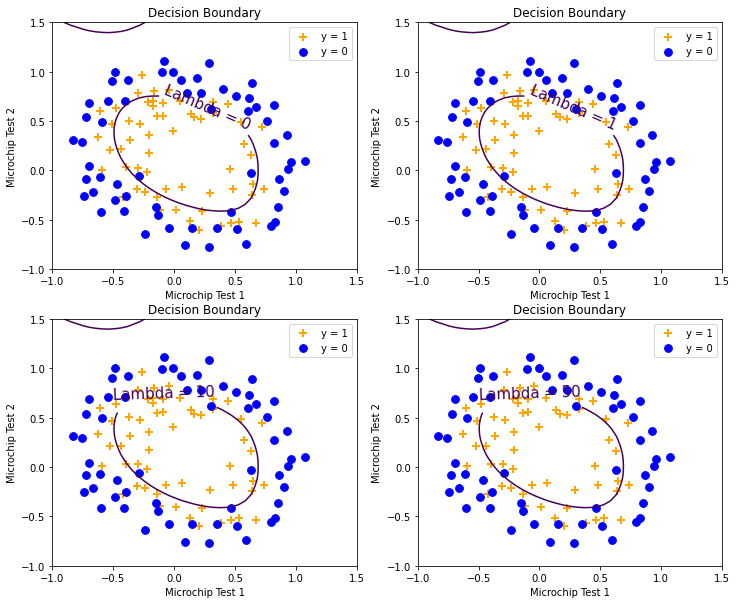

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(XX, y)

plt.subplot(222)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(XX,y,1.)

plt.subplot(223)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(XX,y,10.)

plt.subplot(224)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(XX,y,50.)